In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import cv2
##Para conectar con el drive
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import io,filters
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH= '/content/drive/Shareddrives/Los mejorcitos/BD 810/BD 810/'

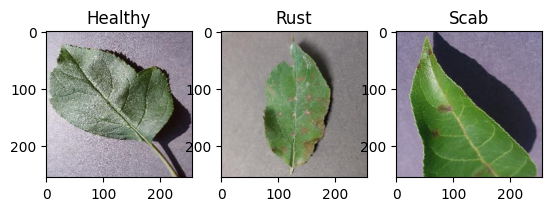

In [39]:
##SANA
image1 = cv2.imread(PATH + "Copia de 1" + ".jpg", cv2.IMREAD_COLOR)
img_gray1 = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY) 
hsv1 = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
image4 = cv2.imread(PATH + "Copia de 100" + ".jpg", cv2.IMREAD_COLOR)
image7 = cv2.imread(PATH + "Copia de 260" + ".jpg", cv2.IMREAD_COLOR)

##RUST (Roya)
image2 = cv2.imread(PATH + "Copia de 342" + ".jpg", cv2.IMREAD_COLOR)
img_gray2 = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY) 
hsv2 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
image5 = cv2.imread(PATH + "Copia de 275" + ".jpg", cv2.IMREAD_COLOR)
image8 = cv2.imread(PATH + "Copia de 500" + ".jpg", cv2.IMREAD_COLOR)

##SCAB (Sarna)
image3 = cv2.imread(PATH + "Copia de 588" + ".jpg", cv2.IMREAD_COLOR)
img_gray3 = cv2.cvtColor(image3,cv2.COLOR_BGR2GRAY) 
hsv2 = cv2.cvtColor(image3, cv2.COLOR_BGR2HSV)
image6 = cv2.imread(PATH + "Copia de 600" + ".jpg", cv2.IMREAD_COLOR)
image9 = cv2.imread(PATH + "Copia de 700" + ".jpg", cv2.IMREAD_COLOR)



plt.subplot(131)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Healthy')

plt.subplot(132)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Rust')

plt.subplot(133)
plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
plt.title('Scab')

plt.show()

Funcion sin umbral adaptativo

In [ ]:
def retinex_correction(image, sigma=50):
    # Convertir la imagen al espacio de color logarítmico
    log_image = np.log1p(image.astype(np.float32))

    # Calcular el tamaño del kernel para el filtro Gaussiano
    ksize = (sigma * 6 + 1, sigma * 6 + 1)
    ksize = (ksize[0] // 2 * 2 + 1, ksize[1] // 2 * 2 + 1)  # Asegurar un tamaño impar

    # Aplicar el filtro Gaussiano en la imagen logarítmica
    blur_image = cv2.GaussianBlur(log_image, ksize, 0)

    # Calcular la diferencia entre la imagen logarítmica original y la filtrada
    diff_image = log_image - blur_image

    # Obtener la imagen corregida sumando la diferencia a la imagen original
    corrected_image = np.clip(image + diff_image, 0, 255).astype(np.uint8)

    return corrected_image

def preprocess_image(image):
    # Aplicar la corrección de iluminación Retinex
    corrected_image = retinex_correction(image)

    # Convertir la imagen corregida al espacio de color HSV
    hsv = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color de la hoja en HSV
    lower_green = np.array([30, 30, 30])
    upper_green = np.array([100, 255, 255])  # Ajustar los valores para incluir más tonos de verde

    # Crear una máscara para la zona verde
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Aplicar operaciones morfológicas para eliminar el ruido y mejorar los bordes
    kernel = np.ones((5, 5), np.uint8)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Aplicar detección de contornos y eliminar los contornos pequeños
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 1000  # Área mínima del contorno para considerar como zona verde
    for contour in contours:
        if cv2.contourArea(contour) < min_contour_area:
            cv2.drawContours(green_mask, [contour], -1, 0, thickness=cv2.FILLED)

    # Aplicar las máscaras a la imagen original
    green_segmented = cv2.bitwise_and(image, image, mask=green_mask)

    # Retornar la imagen segmentada de la zona verde
    return green_segmented

Función con umbral adaptativo

In [32]:
def correccion_brillo_adaptativo(image):
    # Convertir la imagen al espacio de color LAB
    imagen_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Separar los canales de la imagen LAB
    canal_l, canal_a, canal_b = cv2.split(imagen_lab)

    # Calcular el umbral adaptativo para el canal L
    umbral_superior = np.mean(canal_l) + np.std(canal_l)
    umbral_inferior = np.mean(canal_l) - np.std(canal_l)

    # Realizar la corrección de brillo adaptativa
    if np.mean(canal_l) > umbral_superior:
        factor_ajuste = 1.2  # Ajuste para disminuir el brillo
    elif np.mean(canal_l) < umbral_inferior:
        factor_ajuste = 0.8  # Ajuste para aumentar el brillo
    else:
        factor_ajuste = 1.0  # Sin ajuste de brillo

    canal_l_ajustado = cv2.multiply(canal_l, factor_ajuste)

    # Combinar los canales LAB ajustados
    imagen_lab_ajustada = cv2.merge([canal_l_ajustado, canal_a, canal_b])

    # Convertir la imagen de vuelta al espacio de color BGR
    imagen_ajustada = cv2.cvtColor(imagen_lab_ajustada, cv2.COLOR_LAB2BGR)

    return imagen_ajustada

def retinex_correction(image, sigma=50):
    # Aplicar la corrección de brillo
    #imagen_ajustada = correccion_brillo_adaptativo(image)
    # Convertir la imagen al espacio de color logarítmico
    log_image = np.log1p(image.astype(np.float32))

    # Calcular el tamaño del kernel para el filtro Gaussiano
    ksize = (sigma * 6 + 1, sigma * 6 + 1)
    ksize = (ksize[0] // 2 * 2 + 1, ksize[1] // 2 * 2 + 1)  # Asegurar un tamaño impar

    # Aplicar el filtro Gaussiano en la imagen logarítmica
    blur_image = cv2.GaussianBlur(log_image, ksize, 0)

    # Calcular la diferencia entre la imagen logarítmica original y la filtrada
    diff_image = log_image - blur_image

    # Obtener la imagen corregida sumando la diferencia a la imagen original
    corrected_image = np.clip(image + diff_image, 0, 255).astype(np.uint8)

    return corrected_image

def preprocess_image(image):
    # Aplicar la corrección de iluminación Retinex
    corrected_image = retinex_correction(image)

    # Convertir la imagen corregida al espacio de color HSV
    hsv = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color de la hoja en HSV
    lower_green = np.array([30, 30, 30])
    upper_green = np.array([100, 255, 255])  # Ajustar los valores para incluir más tonos de verde
    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    #lower_green_additional = np.array([99, 0, 63])
    #upper_green_additional = np.array([119, 19, 73])
    lower_green_additional = np.array([25, 0, 0])
    upper_green_additional = np.array([40, 255, 255])
    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    lower_green_additional_2 = np.array([50, 0, 0])
    upper_green_additional_2 = np.array([70, 255, 255])

    # Crear una máscara para la zona verde
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Aplicar la máscara adicional de zona verde más birllante
    mask_additional = cv2.inRange(hsv, lower_green_additional, upper_green_additional)

    # Aplicar la máscara adicional 2 al espacio de color HSV
    mask_additional_2 = cv2.inRange(hsv, lower_green_additional_2, upper_green_additional_2)

      # Combinar las máscaras actual y adicional
    mask_combined = cv2.bitwise_or(green_mask, mask_additional)

    # Combinar las máscaras actual, adicional y adicional 2
    mask_combined = cv2.bitwise_or(mask_combined, mask_additional_2)

    # Aplicar operaciones morfológicas para eliminar el ruido y mejorar los bordes
    kernel = np.ones((5, 5), np.uint8)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=2)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Aplicar detección de contornos y eliminar los contornos pequeños
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 1000  # Área mínima del contorno para considerar como zona verde
    for contour in contours:
        if cv2.contourArea(contour) < min_contour_area:
            cv2.drawContours(green_mask, [contour], -1, 0, thickness=cv2.FILLED)

    # Aplicar las máscaras a la imagen original
    green_segmented = cv2.bitwise_and(image, image, mask=green_mask)

    # Retornar la imagen segmentada de la zona verde
    return green_segmented


Text(0.5, 1.0, 'Scab')

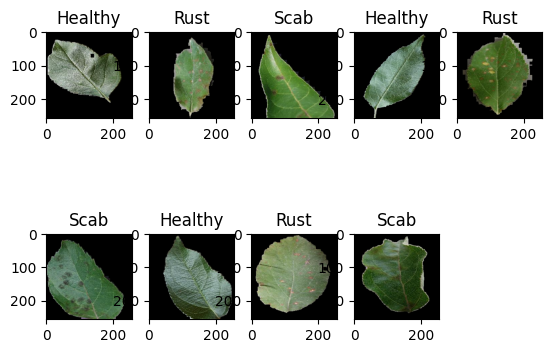

In [41]:
# Preprocesar la imagen
#hsv = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
green_segmented1 = preprocess_image(image1)
#hsv = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
green_segmented2 = preprocess_image(image2)
#hsv = cv2.cvtColor(image3, cv2.COLOR_BGR2HSV)
green_segmented3 = preprocess_image(image3)
green_segmented4 = preprocess_image(image4)
green_segmented5 = preprocess_image(image5)
green_segmented6 = preprocess_image(image6)
green_segmented7 = preprocess_image(image7)
green_segmented8 = preprocess_image(image8)
green_segmented9 = preprocess_image(image9)

plt.subplot(251)
plt.imshow(cv2.cvtColor(green_segmented1, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(252)
plt.imshow(cv2.cvtColor(green_segmented2, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(253)
plt.imshow(cv2.cvtColor(green_segmented3, cv2.COLOR_BGR2RGB))
plt.title('Scab')
plt.subplot(254)
plt.imshow(cv2.cvtColor(green_segmented4, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(255)
plt.imshow(cv2.cvtColor(green_segmented5, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(256)
plt.imshow(cv2.cvtColor(green_segmented6, cv2.COLOR_BGR2RGB))
plt.title('Scab')
plt.subplot(257)
plt.imshow(cv2.cvtColor(green_segmented7, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(258)
plt.imshow(cv2.cvtColor(green_segmented8, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(259)
plt.imshow(cv2.cvtColor(green_segmented9, cv2.COLOR_BGR2RGB))
plt.title('Scab')


Mejorar el código para que tome partes verdes y cafés

In [48]:
def correccion_brillo_adaptativo(image):
    # Convertir la imagen al espacio de color LAB
    imagen_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Separar los canales de la imagen LAB
    canal_l, canal_a, canal_b = cv2.split(imagen_lab)

    # Calcular el umbral adaptativo para el canal L
    umbral_superior = np.mean(canal_l) + np.std(canal_l)
    umbral_inferior = np.mean(canal_l) - np.std(canal_l)

    # Realizar la corrección de brillo adaptativa
    if np.mean(canal_l) > umbral_superior:
        factor_ajuste = 1.2  # Ajuste para disminuir el brillo
    elif np.mean(canal_l) < umbral_inferior:
        factor_ajuste = 0.8  # Ajuste para aumentar el brillo
    else:
        factor_ajuste = 1.0  # Sin ajuste de brillo

    canal_l_ajustado = cv2.multiply(canal_l, factor_ajuste)

    # Combinar los canales LAB ajustados
    imagen_lab_ajustada = cv2.merge([canal_l_ajustado, canal_a, canal_b])

    # Convertir la imagen de vuelta al espacio de color BGR
    imagen_ajustada = cv2.cvtColor(imagen_lab_ajustada, cv2.COLOR_LAB2BGR)

    return imagen_ajustada

def retinex_correction(image, sigma=50):
    # Aplicar la corrección de brillo
    #imagen_ajustada = correccion_brillo_adaptativo(image)
    # Convertir la imagen al espacio de color logarítmico
    log_image = np.log1p(image.astype(np.float32))

    # Calcular el tamaño del kernel para el filtro Gaussiano
    ksize = (sigma * 6 + 1, sigma * 6 + 1)
    ksize = (ksize[0] // 2 * 2 + 1, ksize[1] // 2 * 2 + 1)  # Asegurar un tamaño impar

    # Aplicar el filtro Gaussiano en la imagen logarítmica
    blur_image = cv2.GaussianBlur(log_image, ksize, 0)

    # Calcular la diferencia entre la imagen logarítmica original y la filtrada
    diff_image = log_image - blur_image

    # Obtener la imagen corregida sumando la diferencia a la imagen original
    corrected_image = np.clip(image + diff_image, 0, 255).astype(np.uint8)

    return corrected_image

def preprocess_image(image):
    # Aplicar la corrección de iluminación Retinex
    corrected_image = retinex_correction(image)

    # Convertir la imagen corregida al espacio de color HSV
    hsv = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color de la hoja en HSV
    lower_green = np.array([30, 30, 30])
    upper_green = np.array([100, 255, 255])  # Ajustar los valores para incluir más tonos de verde

    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    lower_green_additional = np.array([25, 0, 0])
    upper_green_additional = np.array([40, 255, 255])

    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    lower_green_additional_2 = np.array([50, 0, 0])
    upper_green_additional_2 = np.array([70, 255, 255])

    # Definir el rango de color adicional en HSV para detectar el tono de café específico
    lower_brown_additional = np.array([20, 50, 50])
    upper_brown_additional = np.array([30, 255, 255])

    # Crear una máscara para la zona verde
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Aplicar la máscara adicional de zona verde más brillante
    mask_additional = cv2.inRange(hsv, lower_green_additional, upper_green_additional)

    # Aplicar la máscara adicional 2 al espacio de color HSV
    mask_additional_2 = cv2.inRange(hsv, lower_green_additional_2, upper_green_additional_2)

    # Aplicar la máscara adicional para el tono de café
    mask_brown_additional = cv2.inRange(hsv, lower_brown_additional, upper_brown_additional)

    # Combinar las máscaras actual, adicional, adicional 2 y café
    mask_combined = cv2.bitwise_or(green_mask, mask_additional)
    mask_combined = cv2.bitwise_or(mask_combined, mask_additional_2)
    mask_combined = cv2.bitwise_or(mask_combined, mask_brown_additional)

    # Aplicar operaciones morfológicas para eliminar el ruido y mejorar los bordes
    kernel = np.ones((5, 5), np.uint8)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=2)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Aplicar detección de contornos y eliminar los contornos pequeños
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 1000  # Área mínima del contorno para considerar como zona verde
    for contour in contours:
        if cv2.contourArea(contour) < min_contour_area:
            cv2.drawContours(green_mask, [contour], -1, 0, thickness=cv2.FILLED)

    # Aplicar las máscaras a la imagen original
    green_segmented = cv2.bitwise_and(image, image, mask=green_mask)

    # Retornar la imagen segmentada de la zona verde
    return green_segmented

Text(0.5, 1.0, 'Scab')

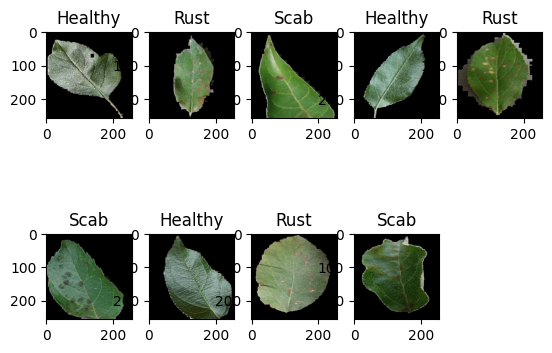

In [49]:
# Preprocesar la imagen
#hsv = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
green_segmented1 = preprocess_image(image1)
#hsv = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
green_segmented2 = preprocess_image(image2)
#hsv = cv2.cvtColor(image3, cv2.COLOR_BGR2HSV)
green_segmented3 = preprocess_image(image3)
green_segmented4 = preprocess_image(image4)
green_segmented5 = preprocess_image(image5)
green_segmented6 = preprocess_image(image6)
green_segmented7 = preprocess_image(image7)
green_segmented8 = preprocess_image(image8)
green_segmented9 = preprocess_image(image9)

plt.subplot(251)
plt.imshow(cv2.cvtColor(green_segmented1, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(252)
plt.imshow(cv2.cvtColor(green_segmented2, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(253)
plt.imshow(cv2.cvtColor(green_segmented3, cv2.COLOR_BGR2RGB))
plt.title('Scab')
plt.subplot(254)
plt.imshow(cv2.cvtColor(green_segmented4, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(255)
plt.imshow(cv2.cvtColor(green_segmented5, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(256)
plt.imshow(cv2.cvtColor(green_segmented6, cv2.COLOR_BGR2RGB))
plt.title('Scab')
plt.subplot(257)
plt.imshow(cv2.cvtColor(green_segmented7, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(258)
plt.imshow(cv2.cvtColor(green_segmented8, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(259)
plt.imshow(cv2.cvtColor(green_segmented9, cv2.COLOR_BGR2RGB))
plt.title('Scab')

# Mejora la detección de la hoja pero elimina partes de interes de la enfermedad

In [46]:
def correccion_brillo_adaptativo(image):
    # Convertir la imagen al espacio de color LAB
    imagen_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Separar los canales de la imagen LAB
    canal_l, canal_a, canal_b = cv2.split(imagen_lab)

    # Calcular el umbral adaptativo para el canal L
    umbral_superior = np.mean(canal_l) + np.std(canal_l)
    umbral_inferior = np.mean(canal_l) - np.std(canal_l)

    # Realizar la corrección de brillo adaptativa
    if np.mean(canal_l) > umbral_superior:
        factor_ajuste = 1.2  # Ajuste para disminuir el brillo
    elif np.mean(canal_l) < umbral_inferior:
        factor_ajuste = 0.8  # Ajuste para aumentar el brillo
    else:
        factor_ajuste = 1.0  # Sin ajuste de brillo

    canal_l_ajustado = cv2.multiply(canal_l, factor_ajuste)

    # Combinar los canales LAB ajustados
    imagen_lab_ajustada = cv2.merge([canal_l_ajustado, canal_a, canal_b])

    # Convertir la imagen de vuelta al espacio de color BGR
    imagen_ajustada = cv2.cvtColor(imagen_lab_ajustada, cv2.COLOR_LAB2BGR)

    return imagen_ajustada

def retinex_correction(image, sigma=50):
    # Aplicar la corrección de brillo
    #imagen_ajustada = correccion_brillo_adaptativo(image)
    # Convertir la imagen al espacio de color logarítmico
    log_image = np.log1p(image.astype(np.float32))

    # Calcular el tamaño del kernel para el filtro Gaussiano
    ksize = (sigma * 6 + 1, sigma * 6 + 1)
    ksize = (ksize[0] // 2 * 2 + 1, ksize[1] // 2 * 2 + 1)  # Asegurar un tamaño impar

    # Aplicar el filtro Gaussiano en la imagen logarítmica
    blur_image = cv2.GaussianBlur(log_image, ksize, 0)

    # Calcular la diferencia entre la imagen logarítmica original y la filtrada
    diff_image = log_image - blur_image

    # Obtener la imagen corregida sumando la diferencia a la imagen original
    corrected_image = np.clip(image + diff_image, 0, 255).astype(np.uint8)

    return corrected_image

def preprocess_image(image):
    # Aplicar la corrección de iluminación Retinex
    corrected_image = retinex_correction(image)

    # Convertir la imagen corregida al espacio de color HSV
    hsv = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color de la hoja en HSV
    lower_green = np.array([30, 30, 30])
    upper_green = np.array([100, 255, 255])  # Ajustar los valores para incluir más tonos de verde

    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    lower_green_additional = np.array([25, 0, 0])
    upper_green_additional = np.array([40, 255, 255])

    # Definir el rango de color adicional en HSV para detectar el tono de verde específico
    lower_green_additional_2 = np.array([50, 0, 0])
    upper_green_additional_2 = np.array([70, 255, 255])

    # Definir el rango de color adicional en HSV para detectar el tono de café específico
    lower_brown_additional = np.array([20, 50, 50])
    upper_brown_additional = np.array([30, 255, 255])

    # Definir el rango de color para excluir el fondo
    lower_background = np.array([15, 20, 10])
    upper_background = np.array([35, 255, 255])

    # Crear una máscara para la zona verde
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Aplicar la máscara adicional de zona verde más brillante
    mask_additional = cv2.inRange(hsv, lower_green_additional, upper_green_additional)

    # Aplicar la máscara adicional 2 al espacio de color HSV
    mask_additional_2 = cv2.inRange(hsv, lower_green_additional_2, upper_green_additional_2)

    # Aplicar la máscara adicional para el tono de café
    mask_brown_additional = cv2.inRange(hsv, lower_brown_additional, upper_brown_additional)

    # Crear una máscara para excluir el fondo
    background_mask = cv2.inRange(hsv, lower_background, upper_background)

    # Combinar las máscaras actual, adicional, adicional 2 y café
    mask_combined = cv2.bitwise_or(green_mask, mask_additional)
    mask_combined = cv2.bitwise_or(mask_combined, mask_additional_2)
    mask_combined = cv2.bitwise_or(mask_combined, mask_brown_additional)

    # Aplicar operaciones morfológicas para eliminar el ruido y mejorar los bordes
    kernel = np.ones((5, 5), np.uint8)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=2)
    green_mask = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Excluir el fondo de la máscara final
    green_mask = cv2.bitwise_and(green_mask, cv2.bitwise_not(background_mask))

    # Aplicar detección de contornos y eliminar los contornos pequeños
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 1000  # Área mínima del contorno para considerar como zona verde
    for contour in contours:
        if cv2.contourArea(contour) < min_contour_area:
            cv2.drawContours(green_mask, [contour], -1, 0, thickness=cv2.FILLED)

    # Aplicar las máscaras a la imagen original
    green_segmented = cv2.bitwise_and(image, image, mask=green_mask)

    # Retornar la imagen segmentada de la zona verde
    return green_segmented


Text(0.5, 1.0, 'Scab')

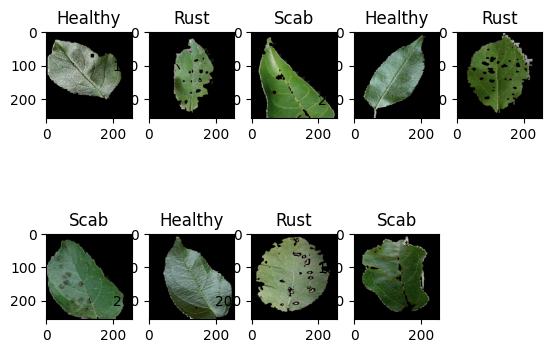

In [47]:
# Preprocesar la imagen
#hsv = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
green_segmented1 = preprocess_image(image1)
#hsv = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
green_segmented2 = preprocess_image(image2)
#hsv = cv2.cvtColor(image3, cv2.COLOR_BGR2HSV)
green_segmented3 = preprocess_image(image3)
green_segmented4 = preprocess_image(image4)
green_segmented5 = preprocess_image(image5)
green_segmented6 = preprocess_image(image6)
green_segmented7 = preprocess_image(image7)
green_segmented8 = preprocess_image(image8)
green_segmented9 = preprocess_image(image9)

plt.subplot(251)
plt.imshow(cv2.cvtColor(green_segmented1, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(252)
plt.imshow(cv2.cvtColor(green_segmented2, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(253)
plt.imshow(cv2.cvtColor(green_segmented3, cv2.COLOR_BGR2RGB))
plt.title('Scab')
plt.subplot(254)
plt.imshow(cv2.cvtColor(green_segmented4, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(255)
plt.imshow(cv2.cvtColor(green_segmented5, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(256)
plt.imshow(cv2.cvtColor(green_segmented6, cv2.COLOR_BGR2RGB))
plt.title('Scab')
plt.subplot(257)
plt.imshow(cv2.cvtColor(green_segmented7, cv2.COLOR_BGR2RGB))
plt.title('Healthy')
plt.subplot(258)
plt.imshow(cv2.cvtColor(green_segmented8, cv2.COLOR_BGR2RGB))
plt.title('Rust')
plt.subplot(259)
plt.imshow(cv2.cvtColor(green_segmented9, cv2.COLOR_BGR2RGB))
plt.title('Scab')